## Cell 1:

In [1]:
#Cell 1
# okay, so---make a bunch of convolved images
# turn them into simple catalogs
# then calculate the fwhm of the star-like objects in the resultant catalog
# only challenge--I need a seeing FWHM for this thing to run.
#hmm. what do I use for real source extractor runnings? default_dualmode.sex says:
#I manually set it to 0.195 for the F105w filter, and 0.204 for the F606w filter. 
#if I remember correctly, this is mostly used for class_star separation, but that does sort of play a role in
#figuring out what the fwhm of the stars are, which is exactly what we need
#

## Cell 2:

In [2]:
#cell 2
import numpy as np
import array as arr
from astropy import table
#from reproject import reproject_exact ;not reprojecting in here
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.io import fits
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
import sewpy
import iterate_convolution as ic
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join
import astropy.table



## Cell 3:

In [3]:
#cell 3
#original files to work with
#@@@
fileblue='/home/wes/Astronomy/Data/GoGreen/j020548m5829/PreData/j020548m5829-f606w_drc_sci.fits'
filered='/home/wes/Astronomy/Data/GoGreen/j020548m5829/PreData/j020548m5829-f140w_drz_sci.fits'
filereprojd='/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205.fits'
#this reprojd file is the output of the reprojectin.py program

h_red=fits.open(filered)
h_blue=fits.open(filereprojd)
h_original=fits.open(fileblue)
hdr_red=h_red[0].header
hdr_reprj=h_blue[0].header
hdr_ogblue=h_original[0].header
ident1='sept21_'
ident2='sept21b_'


#FWHM for Hubble
#FWHM[rad] = 2.44 * lamda / diameter
#diameter = 2.4 m
hubbleDiameter = 2.4 * (10**10) #angstrom

blueWavelength = 6060 #angstrom
redWavelength = 14000 #angstrom

fwhm_blue_rad = 2.44 * blueWavelength/hubbleDiameter 
fwhm_red_rad = 2.44 * redWavelength/hubbleDiameter 


#@@@
fwhm_blue_pix = 2.5 #well, you need to measure this using imexamine/topcat; this should be true for both blue images, original and reprojected
fwhm_red_pix = 1.85 #well, you need to measure this as ^ #$$$

Ouch, SExtractor complains :
b''
/tmp/ipykernel_7045/870298192.py:7: RuntimeWarning: invalid value encountered in log10
  logFlux = (-2.5)*np.log10(table_red['FLUX_AUTO'])


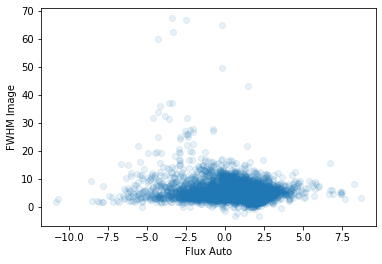

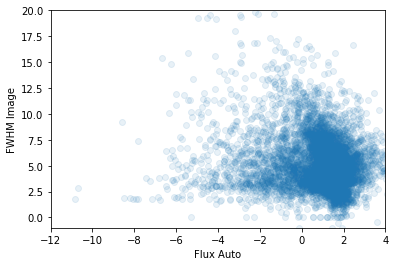

Ouch, SExtractor complains :
b''


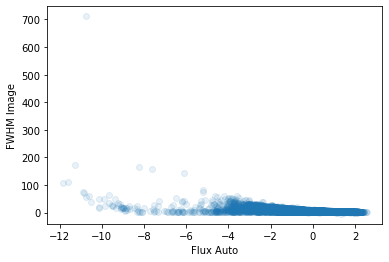

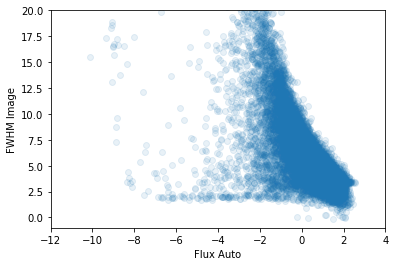

In [15]:
#calculate real fwhm
table_red=ic.makecat(filered,see=fwhm_red_arc)
#print(table_red)
#print(table_red['FWHM_IMAGE'])
#print(table_red['FLUX_APER'])
my_fwhm = table_red['FWHM_IMAGE']
logFlux = (-2.5)*np.log10(table_red['FLUX_AUTO']) 

plt.scatter(logFlux,my_fwhm,alpha=0.1)
plt.xlabel('Flux Auto')
plt.ylabel('FWHM Image')
plt.show()
plt.clf()
plt.scatter(logFlux,my_fwhm,alpha=0.1)
plt.xlabel('Flux Auto Red')
plt.ylabel('FWHM Image')
plt.xlim(-12,4)
plt.ylim(-1,20)
plt.show()


#calculate real fwhm
table_blue=ic.makecat(fileblue,see=fwhm_blue_arc)
#print(table_red)
#print(table_red['FWHM_IMAGE'])
#print(table_red['FLUX_APER'])
my_fwhm = table_blue['FWHM_IMAGE']
logFlux = (-2.5)*np.log10(table_blue['FLUX_AUTO']) 

plt.scatter(logFlux,my_fwhm,alpha=0.1)
plt.xlabel('Flux Auto Blue')
plt.ylabel('FWHM Image')
plt.show()
plt.clf()
plt.scatter(logFlux,my_fwhm,alpha=0.1)
plt.xlabel('Flux Auto')
plt.ylabel('FWHM Image')
plt.xlim(-12,4)
plt.ylim(-1,20)
plt.show()

## Cell 4:

Ouch, SExtractor complains :
b''


filtered data is size: 11


/tmp/ipykernel_7045/4114278377.py:12: RuntimeWarning: invalid value encountered in log10
  pseudomag=(-1.0)*np.log10(table_red['FLUX_APER'])


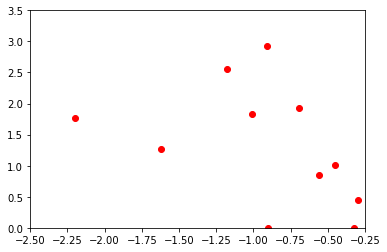

Median FWHM_IMAGE 1.27 Mean FWHM_IMAGE 1.3263636363636364
0.12699999999999645
fwhmbluearc 0.1270798665
already convolved
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_0.fits
already convolved
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_1.fits
already convolved
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_2.fits
already convolved
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_3.fits
already convolved
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_4.fits
already convolved
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_5.fits
already convolved
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_6.fits
already convolved
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_7.fits
already convolved
/home/wes/Astronomy/Dat

In [4]:
#cell 4
# iterative convolution
#do some calculations about the range of convolution kernels to try

cd1_red=hdr_red['CD1_1']
#!!!
cd1_red_arc=abs(cd1_red) * 3600.0
fwhm_red_arc= fwhm_red_pix*cd1_red_arc
#use calculated fwhm instead of hand measured
fwhm_red_arc = fwhm_red_rad*206265
table_red=ic.makecat(filered,see=fwhm_red_arc)
pseudomag=(-1.0)*np.log10(table_red['FLUX_APER'])
table_red['MAG']=pseudomag #calcfwhm won't run without a 'Mag' column to select the most 'stellar sequence' of objects
redtable_temp=ic.calcfwhm(table_red,star_limit=0.8,maglow=-2.5,maghigh=-0.25,fwhmlim=3.5, plottin = True)
fwhm_red_recalcd=np.median(redtable_temp['FWHM_IMAGE'])#$$$
fwhm_red_recalc_arc=fwhm_red_recalcd*cd1_red_arc#!!!
print(fwhm_red_recalc_arc)

#only need this to get a reasonable range for the convolution kernels to try
#!!!
#cd1_blue=hdr_ogblue['CD1_1']
cd1_blue=hdr_reprj['CD1_1']
cd1_blue_arc=abs(cd1_blue)*3600.0
fwhm_blue_arc=fwhm_blue_pix*cd1_blue_arc#!!!
#use calculated
fwhm_blue_arc = fwhm_blue_rad * 206265
print('fwhmbluearc',fwhm_blue_arc)

#only need this to convert to the correct pixel scale.
#!!!
cd1_reproj=hdr_reprj['CD1_1']
cd1_reproj_arc=abs(cd1_reproj)*3600.0


##Below, we do a first pass at a variety of convolution kernels and then take a look at their results

########an average in-between value would be calculated like this: fwhm2=((fwhmarcred**2.0)-(fwhmarcblue**2.0))**(1/2)
#or set up an array to do several convolutions, which is what is below.

#WES: If the fwhm of blue is smaller, try div 6 instead of div 4 -- play around with this
#yarray1=np.linspace(fwhm_red_recalc_arc,fwhm_blue_arc,15,endpoint=True)
yarray1=np.linspace(fwhm_red_recalc_arc/2.,fwhm_blue_arc/4.,15,endpoint=True)
#that's an appropriate range in arcseconds
yarray=yarray1/cd1_reproj_arc#!!!
#now it's in pixels
#print(yarray1)


m=0
files=[]
for item in yarray: #switch this yarray to yarr2 for next iteration
    filename=ic.conv2Dgauss(filereprojd,item,i=m,ident=ident1)
    m+=1
    files.append(filename)
    print(filename)
print('done convolving')


In [17]:
print(yarray1)

[0.057      0.05590476 0.05480952 0.05371429 0.05261905 0.05152381
 0.05042857 0.04933333 0.0482381  0.04714286 0.04604762 0.04495238
 0.04385714 0.0427619  0.04166667]


## Cell 5:

Ouch, SExtractor complains :
b''


/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_0.fits
convolved by FWHM 0.5700000000000001 pixels, aka 0.05699999999999841 arcsec kernel


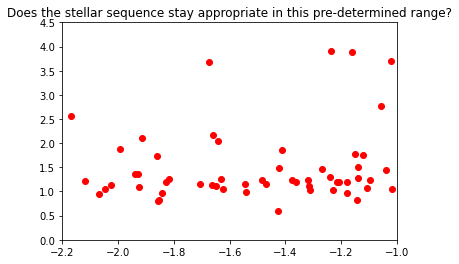

Ouch, SExtractor complains :
b''


filtered data is size: 49
Median FWHM_IMAGE 1.23 Mean FWHM_IMAGE 1.2967346938775512
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_1.fits
convolved by FWHM 0.5590476190476191 pixels, aka 0.05590476190476035 arcsec kernel


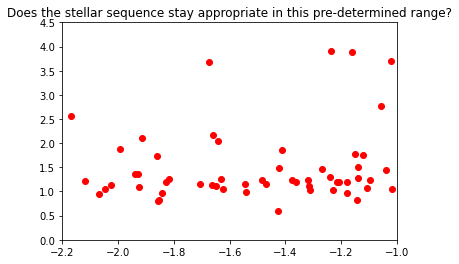

Ouch, SExtractor complains :
b''


filtered data is size: 49
Median FWHM_IMAGE 1.23 Mean FWHM_IMAGE 1.296734693877551
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_2.fits
convolved by FWHM 0.5480952380952382 pixels, aka 0.05480952380952228 arcsec kernel


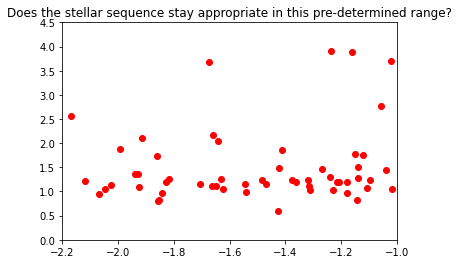

Ouch, SExtractor complains :
b''


filtered data is size: 49
Median FWHM_IMAGE 1.23 Mean FWHM_IMAGE 1.296530612244898
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_3.fits
convolved by FWHM 0.5371428571428571 pixels, aka 0.053714285714284216 arcsec kernel


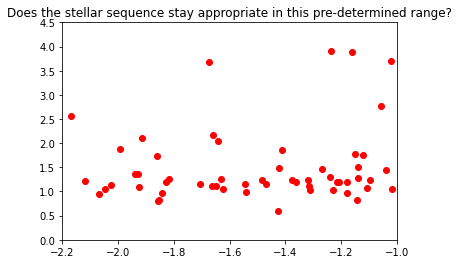

Ouch, SExtractor complains :
b''


filtered data is size: 49
Median FWHM_IMAGE 1.23 Mean FWHM_IMAGE 1.296530612244898
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_4.fits
convolved by FWHM 0.5261904761904762 pixels, aka 0.05261904761904615 arcsec kernel


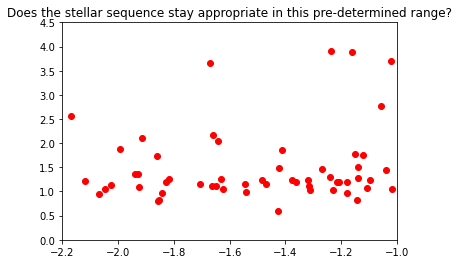

Ouch, SExtractor complains :
b''


filtered data is size: 49
Median FWHM_IMAGE 1.23 Mean FWHM_IMAGE 1.296530612244898
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_5.fits
convolved by FWHM 0.5152380952380953 pixels, aka 0.051523809523808084 arcsec kernel


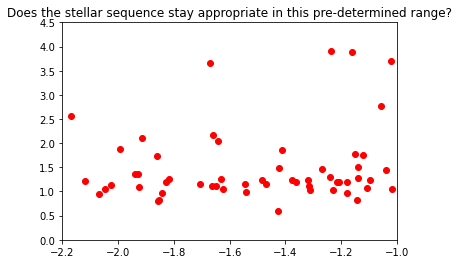

Ouch, SExtractor complains :
b''


filtered data is size: 49
Median FWHM_IMAGE 1.23 Mean FWHM_IMAGE 1.296530612244898
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_6.fits
convolved by FWHM 0.5042857142857143 pixels, aka 0.05042857142857002 arcsec kernel


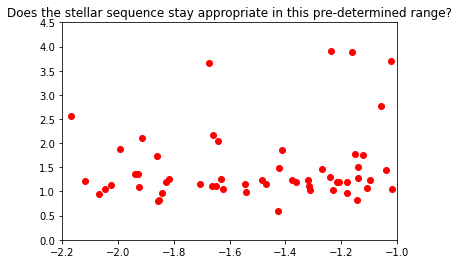

Ouch, SExtractor complains :
b''


filtered data is size: 49
Median FWHM_IMAGE 1.23 Mean FWHM_IMAGE 1.296530612244898
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_7.fits
convolved by FWHM 0.49333333333333335 pixels, aka 0.04933333333333195 arcsec kernel


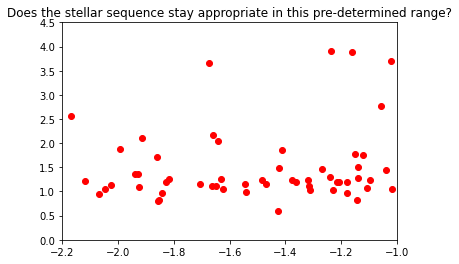

Ouch, SExtractor complains :
b''


filtered data is size: 49
Median FWHM_IMAGE 1.23 Mean FWHM_IMAGE 1.296326530612245
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_8.fits
convolved by FWHM 0.48238095238095235 pixels, aka 0.04823809523809389 arcsec kernel


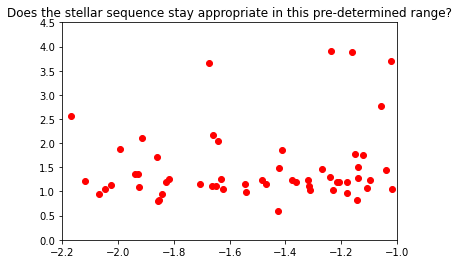

Ouch, SExtractor complains :
b''


filtered data is size: 49
Median FWHM_IMAGE 1.23 Mean FWHM_IMAGE 1.296122448979592
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_9.fits
convolved by FWHM 0.4714285714285714 pixels, aka 0.04714285714285582 arcsec kernel


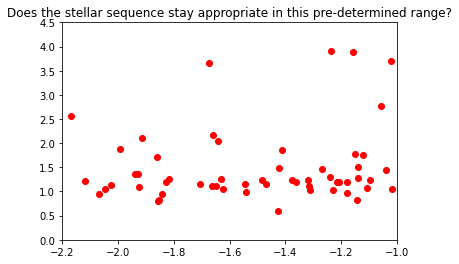

Ouch, SExtractor complains :
b''


filtered data is size: 49
Median FWHM_IMAGE 1.23 Mean FWHM_IMAGE 1.296122448979592
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_10.fits
convolved by FWHM 0.46047619047619043 pixels, aka 0.046047619047617755 arcsec kernel


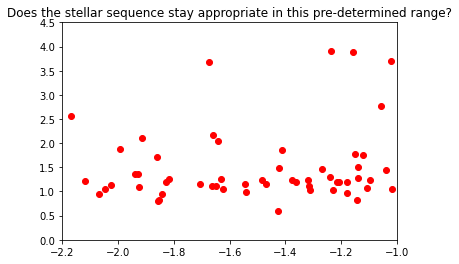

filtered data is size: 49
Median FWHM_IMAGE 1.23 Mean FWHM_IMAGE 1.296122448979592
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_11.fits
convolved by FWHM 0.44952380952380955 pixels, aka 0.044952380952379696 arcsec kernel


Ouch, SExtractor complains :
b''


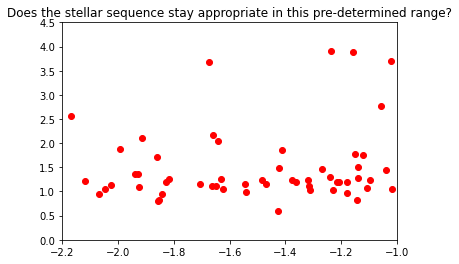

Ouch, SExtractor complains :
b''


filtered data is size: 49
Median FWHM_IMAGE 1.23 Mean FWHM_IMAGE 1.296122448979592
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_12.fits
convolved by FWHM 0.43857142857142856 pixels, aka 0.04385714285714163 arcsec kernel


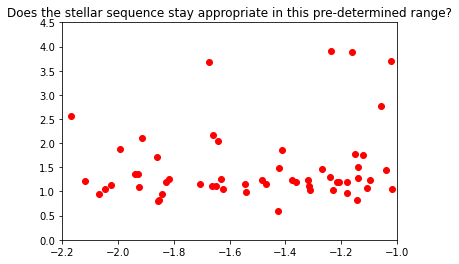

Ouch, SExtractor complains :
b''


filtered data is size: 49
Median FWHM_IMAGE 1.23 Mean FWHM_IMAGE 1.296122448979592
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_13.fits
convolved by FWHM 0.4276190476190476 pixels, aka 0.042761904761903564 arcsec kernel


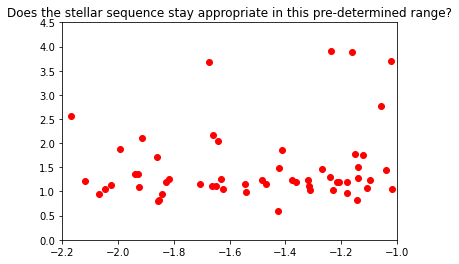

Ouch, SExtractor complains :
b''


filtered data is size: 49
Median FWHM_IMAGE 1.23 Mean FWHM_IMAGE 1.295918367346939
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_14.fits
convolved by FWHM 0.41666666666666663 pixels, aka 0.0416666666666655 arcsec kernel


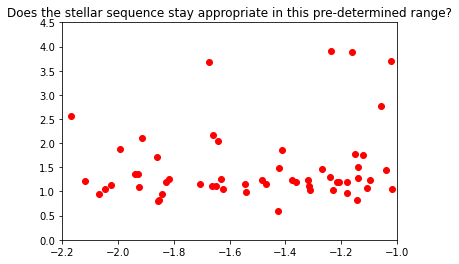

filtered data is size: 49
Median FWHM_IMAGE 1.23 Mean FWHM_IMAGE 1.295918367346939
-------------


In [14]:
#cell 5
#now need to run SE, make a table, and find out how to work with that table
#from making a catalog and visually inspecting it with topcat, we found convolved j2106_f606w's best stellar sequence is fwhm_image <5 mag -2.2 to -1.0
#these parameters are adjustable with default keywords in the calcfwhm function but at the end of the day they will rely somewhat on the fwhm_red_pix and fwhm_blue_pix set in the 2nd cell of this notebook to eventually define what is and is not a star.
#therefore star_limit keyword (which refers to the value of the CLASS_STAR parameter from Source Extractor) can indeed vary significantly depending on what is fed into makecat for the see parameter. I default use fwhm_red_arc (must be in arc per SE's requirements) since that is going to be  unconvolved/we are putting the convolved blue values in TERMS of the red image.
#outdated(newest is sep21)

fwhm_median=[]
i=0
for item in files:
    print(item)
    yval=yarray[i] #in pixels
    yval2=yarray1[i]
    print('convolved by FWHM',yval,'pixels, aka',yval2,'arcsec kernel')
    table1=ic.makecat(item,see=fwhm_red_recalc_arc)
    pseudomags=(-1.0)*np.log10(table1['FLUX_APER'])
    table1['MAG']=pseudomags
    ##
    plt.plot(table1['MAG'],table1['FWHM_IMAGE'],'ro')
    plt.title('Does the stellar sequence stay appropriate in this pre-determined range?')
    plt.ylim(0.0,4.5)
    plt.xlim(-2.2,-1.0)
    plt.show()
    ##
    newlimitedtable=ic.calcfwhm(table1)
    #you can enter plottin=True as an optional argument in calcfwhm
    #that lets you see the stellar sequence that falls in the selection range used for making a new, limited table
    fwhmmed=np.median(newlimitedtable['FWHM_IMAGE'])#draw a line here, should match with stars
    fwhm_median.append(fwhmmed)
    print('-------------')
    i+=1

## Cell 6:

well, originally...


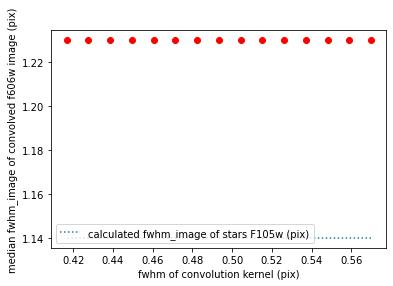

[0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09 0.09
 0.09]


TypeError: only size-1 arrays can be converted to Python scalars

In [21]:
##cell 6
#USE THIS PLOT TO MAKE A QUICK DETERMINATION OF WHAT CONVOLUTION KERNEL BEST RE-PRODUCES THE FWHM OF THE RED IMAGE
#the short code below plt.show() does the calculation for you to find k, the identifier for the best-fit kernel fwhm
#also note that due to the yarray set-up, it plots the points from right to left
#so count from right to left if you use the image.

print('well, originally...')
plt.plot(yarray,fwhm_median,'ro')
#plt.hlines(fwhm_red_pix,xmin=yarray[0],xmax=yarray[len(yarray)-1],label='measured fwhm of F105 image (pix)')
plt.hlines(fwhm_red_recalcd,xmin=yarray[0],xmax=yarray[len(yarray)-1],label='calculated fwhm_image of stars F105w (pix)',linestyle=':')
plt.xlabel('fwhm of convolution kernel (pix)')
plt.ylabel('median fwhm_image of convolved f606w image (pix)')
plt.legend()
plt.show()

#this figures out which of the results is the best fit to the required PSF
s=abs(fwhm_median-fwhm_red_recalcd)
g=[]
#b='%.3f'%s[:]
#print(b)
#!!!
for n in s:
    f='%.3f'%n
    r= float(f) == np.around(s.min(),3)
    g.append(r)

print(s)
k= int(np.where(g)[0])
#print('the file identifier that produces the best psf fitting is',k,'which uses a FWHM of',fwhm_median[k])
print('the file identifier that produces the best psf fitting is',k,'which outputs a FWHM of',fwhm_median[k])
print('originally, red image\'s median FWHM was',fwhm_red_recalcd)
print('so that means, either go onward to calculate a more precise kernel (probably for the best), or use ',files[k])

## Cell 7:

In [7]:
#cell 7
#For a more accurate convolution, take the best fit point at k and convolve more closely around it.
#
#use yarr2 in replace of yarray1
ymax=yarray1[k]+0.01
ymin=yarray1[k]-0.01
ya2=np.linspace(ymax,ymin,20,endpoint=True)
yarr2=ya2/cd1_reproj_arc


i=0
files2=[]
for item2 in yarr2: #now use yarr2 for higher precision
    filename2=ic.conv2Dgauss(filereprojd,item2,i,ident=ident2)
    i+=1
    files2.append(filename2)
    print(filename2)
print('done convolving')

already convolved
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_0.fits
already convolved
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_1.fits
already convolved
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_2.fits
already convolved
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_3.fits
already convolved
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_4.fits
already convolved
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_5.fits
already convolved
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_6.fits
already convolved
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_7.fits
already convolved
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_8.fits
already convolved
/home/wes/

## Cell 8:

In [8]:
#cell 8
#the same as Cell 4 above-- calculate the resultant fwhm for the convolved images
fwhm_median2=[]
j=0
for item in files2:
    print(item)
    yval=yarr2[j] #in pixels
    yval2=ya2[j] #in arcsec
    print('convolved by FWHM',yval,'pixels, aka',yval2,'arcsec kernel')
    table2=ic.makecat(item,see=fwhm_red_pix)
    pseudomags2=(-1.0)*np.log10(table2['FLUX_APER'])
    table2['MAG']=pseudomags2
    #plt.plot(table1['MAG'],table1['FWHM_IMAGE'],'ro')
    #plt.title('Does the stellar sequence stay appropriate in this pre-determined range?')
    #plt.ylim(0.0,4.5)
    #plt.xlim(-2.2,-1.0)
    #plt.show() 
    newlimitedtable2=ic.calcfwhm(table2)
    #you can enter plottin=True as an optional argument in calcfwhm
    #that lets you see the stellar sequence that falls in the selection range used for making a new, limited table
    fwhmmed2=np.median(newlimitedtable2['FWHM_IMAGE'])
    fwhm_median2.append(fwhmmed2)
    print('-------------')
    j+=1
    

Ouch, SExtractor complains :
b''


/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_0.fits
convolved by FWHM 0.6700000000000028 pixels, aka 0.06699999999999841 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 63
Median FWHM_IMAGE 1.59 Mean FWHM_IMAGE 1.6793650793650792
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_1.fits
convolved by FWHM 0.6594736842105288 pixels, aka 0.06594736842105103 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 63
Median FWHM_IMAGE 1.56 Mean FWHM_IMAGE 1.661904761904762
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_2.fits
convolved by FWHM 0.6489473684210549 pixels, aka 0.06489473684210367 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 63
Median FWHM_IMAGE 1.54 Mean FWHM_IMAGE 1.6426984126984125
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_3.fits
convolved by FWHM 0.6384210526315809 pixels, aka 0.0638421052631563 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 63
Median FWHM_IMAGE 1.53 Mean FWHM_IMAGE 1.6409523809523807
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_4.fits
convolved by FWHM 0.627894736842107 pixels, aka 0.06278947368420894 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 63
Median FWHM_IMAGE 1.52 Mean FWHM_IMAGE 1.6284126984126985
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_5.fits
convolved by FWHM 0.6173684210526329 pixels, aka 0.06173684210526156 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 63
Median FWHM_IMAGE 1.51 Mean FWHM_IMAGE 1.6134920634920635
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_6.fits
convolved by FWHM 0.606842105263159 pixels, aka 0.0606842105263142 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 63
Median FWHM_IMAGE 1.49 Mean FWHM_IMAGE 1.5993650793650793
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_7.fits
convolved by FWHM 0.596315789473685 pixels, aka 0.05963157894736683 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 63
Median FWHM_IMAGE 1.48 Mean FWHM_IMAGE 1.5755555555555556
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_8.fits
convolved by FWHM 0.585789473684211 pixels, aka 0.05857894736841946 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 62
Median FWHM_IMAGE 1.4649999999999999 Mean FWHM_IMAGE 1.521290322580645
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_9.fits
convolved by FWHM 0.575263157894737 pixels, aka 0.05752631578947209 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 61
Median FWHM_IMAGE 1.46 Mean FWHM_IMAGE 1.479016393442623
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_10.fits
convolved by FWHM 0.5647368421052631 pixels, aka 0.056473684210524726 arcsec kernel
filtered data is size: 61
Median FWHM_IMAGE 1.43 Mean FWHM_IMAGE 1.4665573770491804
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_11.fits
convolved by FWHM 0.554210526315789 pixels, aka 0.05542105263157736 arcsec kernel


Ouch, SExtractor complains :
b''
Ouch, SExtractor complains :
b''


filtered data is size: 61
Median FWHM_IMAGE 1.42 Mean FWHM_IMAGE 1.4552459016393442
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_12.fits
convolved by FWHM 0.5436842105263151 pixels, aka 0.05436842105262999 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 62
Median FWHM_IMAGE 1.41 Mean FWHM_IMAGE 1.4359677419354835
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_13.fits
convolved by FWHM 0.5331578947368412 pixels, aka 0.05331578947368262 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 62
Median FWHM_IMAGE 1.395 Mean FWHM_IMAGE 1.424677419354839
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_14.fits
convolved by FWHM 0.5226315789473672 pixels, aka 0.052263157894735256 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 62
Median FWHM_IMAGE 1.3849999999999998 Mean FWHM_IMAGE 1.4108064516129033
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_15.fits
convolved by FWHM 0.5121052631578932 pixels, aka 0.05121052631578789 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 62
Median FWHM_IMAGE 1.375 Mean FWHM_IMAGE 1.400806451612903
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_16.fits
convolved by FWHM 0.5015789473684191 pixels, aka 0.050157894736840514 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 62
Median FWHM_IMAGE 1.35 Mean FWHM_IMAGE 1.3722580645161295
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_17.fits
convolved by FWHM 0.49105263157894524 pixels, aka 0.04910526315789315 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 62
Median FWHM_IMAGE 1.34 Mean FWHM_IMAGE 1.3632258064516127
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_18.fits
convolved by FWHM 0.48052631578947125 pixels, aka 0.04805263157894578 arcsec kernel


Ouch, SExtractor complains :
b''


filtered data is size: 62
Median FWHM_IMAGE 1.33 Mean FWHM_IMAGE 1.3511290322580645
-------------
/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_19.fits
convolved by FWHM 0.46999999999999725 pixels, aka 0.04699999999999841 arcsec kernel
filtered data is size: 62
Median FWHM_IMAGE 1.32 Mean FWHM_IMAGE 1.3479032258064518
-------------


## Cell 9:

well, originally...


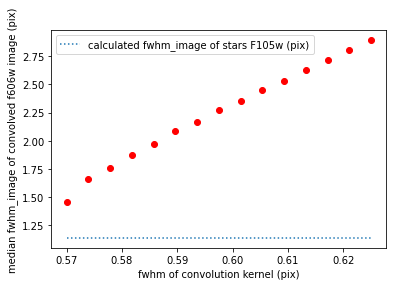

now, with higher accuracy:


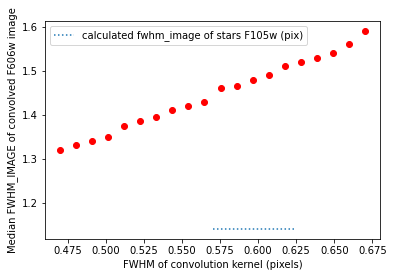

the file identifier that produces the best psf fitting is 19 which uses a FWHM of 1.32
originally, red image's median FWHM was 1.1400000000000001
so use  /home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21b_19.fits


In [9]:
#cell 9
###now, compare the two plots

#also note that due to the yarray set-up, it plots the points from right to left
#so count from right to left if you use the image.
print('well, originally...')
plt.plot(yarray,fwhm_median,'ro')
#plt.hlines(fwhm_red_pix,xmin=yarray[0],xmax=yarray[len(yarray)-1],label='measured fwhm of F105 image (pix)')
plt.hlines(fwhm_red_recalcd,xmin=yarray[0],xmax=yarray[len(yarray)-1],label='calculated fwhm_image of stars F105w (pix)',linestyle=':')
plt.xlabel('fwhm of convolution kernel (pix)')
plt.ylabel('median fwhm_image of convolved f606w image (pix)')
plt.legend()
plt.show()

#also note that due to the yarr2 set-up, it plots the points from right to left
#so count from right to left if you use the image.
print('now, with higher accuracy:')
plt.plot(yarr2,fwhm_median2,'ro')
#plt.hlines(fwhm_red_pix,xmin=yarr2[0],xmax=yarr2[len(yarr2)-1],label='measured FWHM of F105W image (Pixels)')
plt.hlines(fwhm_red_recalcd,xmin=yarray[0],xmax=yarray[len(yarray)-1],label='calculated fwhm_image of stars F105w (pix)',linestyle=':')
plt.xlabel('FWHM of convolution kernel (pixels)')
plt.ylabel('Median FWHM_IMAGE of convolved F606w image')
plt.legend()
plt.show()


o=abs(fwhm_median2-fwhm_red_recalcd)
p=[]
#b='%.3f'%s[:]
#print(b)
for y in o:
    f='%.3f'%y
    r= float(f) == np.around(o.min(),3)
    p.append(r)

t= int(np.where(p)[0])
print('the file identifier that produces the best psf fitting is',t,'which uses a FWHM of',fwhm_median2[t])
print('originally, red image\'s median FWHM was',fwhm_red_recalcd)
print('so use ',files2[t])

# **below this is a mostly obsolete example. 'ware all who enter here**

Ouch, SExtractor complains :
b''
/tmp/ipykernel_21230/1550020436.py:15: RuntimeWarning: invalid value encountered in log10
  magsr=(-1.0)*np.log10(table105['FLUX_APER'])
Ouch, SExtractor complains :
b''


table105 seeing and pixel scale 0.19499999999999454 0.0999999999999972
filtered data is size: 6
Median FWHM_IMAGE 1.55 Mean FWHM_IMAGE 1.4066666666666665
table blue seeing and pixel scale should be familiar 0.2039999999999943 0.0999999999999972
filtered data is size: 44
Median FWHM_IMAGE 2.075 Mean FWHM_IMAGE 2.2940909090909094


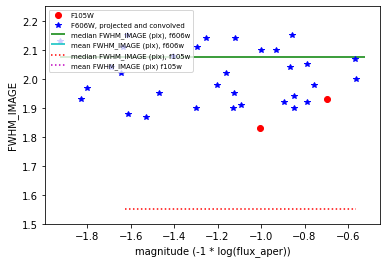

/home/wes/Astronomy/Data/GoGreen/j020548m5829/ProData/newHeader_j0205_conv_sept21_5.fits


In [10]:
####### an example used to see how well a file fits a particular set up. 

goodfilered=filered
hrp=fits.open(goodfilered)
goodfileblue=files[5]

#since feb217 is the 'good one', the best convolution, let's look at the stellar sequence of that compared to F105w
hdr_105=hrp[0].header
fwhmpix105=1.95
cd1_105=hdr_105['CD1_1']
cd105_arc=abs(cd1_105)*3600.0
fwhmarc105=fwhmpix105*cd105_arc
table105=ic.makecat(goodfilered,see=fwhmarc105,ps=cd105_arc)
print('table105 seeing and pixel scale',fwhmarc105,cd105_arc)
magsr=(-1.0)*np.log10(table105['FLUX_APER'])
table105['MAG']=magsr
limitable105=ic.calcfwhm(table105)

blueimage=goodfileblue
hdb=fits.open(blueimage)
hdr_blue2=hdb[0].header
#fpixb=1.95
fpixb=2.04
#gack. where does fpixb come from again? may need to re-measure it
cd_blue2=hdr_blue2['CD1_1']
cd_arcblue2= abs(cd_blue2)*3600.0
farcb=fpixb*cd_arcblue2
tab_blu=ic.makecat(blueimage,see=farcb,ps=cd_arcblue2)
print('table blue seeing and pixel scale should be familiar',farcb,cd_arcblue2)
mblu=(-1.0)*np.log10(tab_blu['FLUX_APER'])
tab_blu['MAG']=mblu
limblu=ic.calcfwhm(tab_blu)

plt.plot(limitable105['MAG'],limitable105['FWHM_IMAGE'],'ro',label='F105W')
plt.plot(limblu['MAG'],limblu['FWHM_IMAGE'],'b*',label='F606W, projected and convolved')
plt.hlines(np.median(limblu['FWHM_IMAGE']),xmin=np.min(limblu['MAG']),xmax=np.max(limblu['MAG']),color='g',label='median FWHM_IMAGE (pix), f606w')
plt.hlines(np.mean(limblu['FWHM_IMAGE']),xmin=np.min(limblu['MAG']),xmax=np.max(limblu['MAG']),color='c',label='mean FWHM_IMAGE (pix), f606w')
plt.hlines(np.median(limitable105['FWHM_IMAGE']),xmin=np.min(limitable105['MAG']),xmax=np.max(limitable105['MAG']),linestyle=':',color='r',label='median FWHM_IMAGE (pix), f105w')
plt.hlines(np.mean(limitable105['FWHM_IMAGE']),xmin=np.min(limitable105['MAG']),xmax=np.max(limitable105['MAG']),color='m',linestyle=':',label='mean FWHM_IMAGE (pix) f105w')
#plt.hlines(1.95,xmin=yarray[0],xmax=yarray[len(yarray)-1],label='measured FWHM of F105W image (Pixels)')
plt.xlabel('magnitude (-1 * log(flux_aper))')
plt.ylim(1.5,2.25)
plt.ylabel('FWHM_IMAGE')
plt.legend(fontsize='x-small',loc="upper left")
plt.show()

print(files[5])


#plt.scatter(limtablereproj['MAG'],limtablereproj['FWHM_IMAGE'])
#plt.scatter(limitable105['MAG'],limitable105['FWHM_IMAGE'])
#plt.show()